In [466]:
import sys
sys.path.append("../../../")

import yfinance as yf
import pandas as pd
import numpy as np
import torch as tc
import matplotlib.pyplot as plt

from scipy.signal import detrend
from scipy.optimize import minimize

from tqdm import tqdm

from rcgp.rcgp import SpatioTemporalRCGP

[*********************100%***********************]  6 of 6 completed


torch.Size([250, 1]) torch.Size([6, 2]) torch.Size([250, 6, 1])


<Axes: xlabel='Date'>

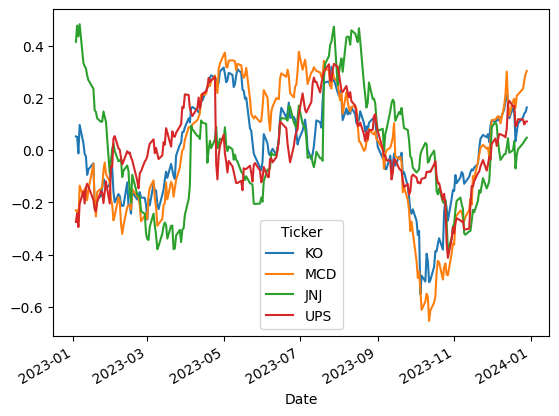

In [465]:
ticks = {
        "KO" : [0.0, 0.0],
        "MCD" : [2, 0.0],

        "UPS" : [-4, 1.0],

        "JNJ" : [7, 4.],   # Johnson & Johnson
        "PG"  : [20., 10.],  # Procter & Gamble

        "XOM" : [100., 100.],   # ExxonMobil
        }

num_assets = len(ticks.keys())

start_date = "2023-01-01"
end_date = "2024-01-01"

data = yf.download(list(ticks.keys()), start=start_date, end=end_date)["Close"]

max = data.max()
min = data.min()
data = (data - min) / (max - min)

for tick in ticks.keys():
    data[tick] = detrend(data[tick])

grid = tc.tensor(list(ticks.values())).float()
ts = tc.arange(len(data.index)).reshape(-1,1).float()
Ys = tc.from_numpy(data.to_numpy()).unsqueeze(-1).float()
print()
print(ts.shape, grid.shape, Ys.shape)

data[["KO", "MCD", "JNJ", "UPS"]].plot()

In [447]:
def scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):
    S = covs + R
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    #energies = 0.5 * (mahalanobis_dist)

    Ws = (Ws / Ws.sum()).squeeze()
    
    return energies.sum()

100%|██████████| 20/20 [00:02<00:00,  7.43it/s]


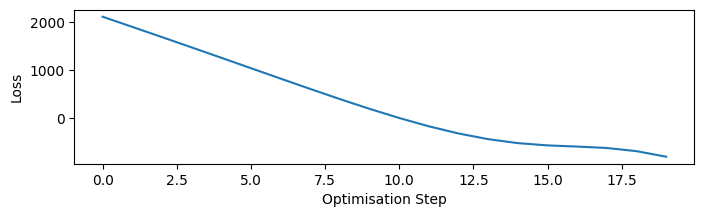

In [611]:
gp = SpatioTemporalRCGP(ts=ts, grid=grid, Ys=Ys, p=1)

gp.activate_robustness(func="constant")
gp.adaptive_c()

losses = []
n_steps = 20
lr = 0.3

optimizer = tc.optim.Adam(gp.parameters(), lr=lr)

for step in tqdm(range(n_steps)):
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=False)   
    loss = scoring_rule(Ys=Ys, preds=preds_filt, covs=covs_filt, R=R, Ws=Ws_norm)
    loss.backward()
    losses.append(loss.clone().detach())
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [612]:
print("Temporal Lengthscale : ", gp.temporal_lengthscale.item())
print("Temporal Magnitude : ", gp.temporal_magnitude.item())
print("Spatial Lengthscale : ", gp.spatial_lengthscale.item())
print("Spatial Magnitude : ", gp.spatial_magnitude.item())
print("Variance (data) : ", gp.var_y.item())

Temporal Lengthscale :  4.485431671142578
Temporal Magnitude :  0.12326323240995407
Spatial Lengthscale :  6.537160873413086
Spatial Magnitude :  0.12326328456401825
Variance (data) :  0.007649546023458242


In [613]:
with tc.no_grad():
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=True)

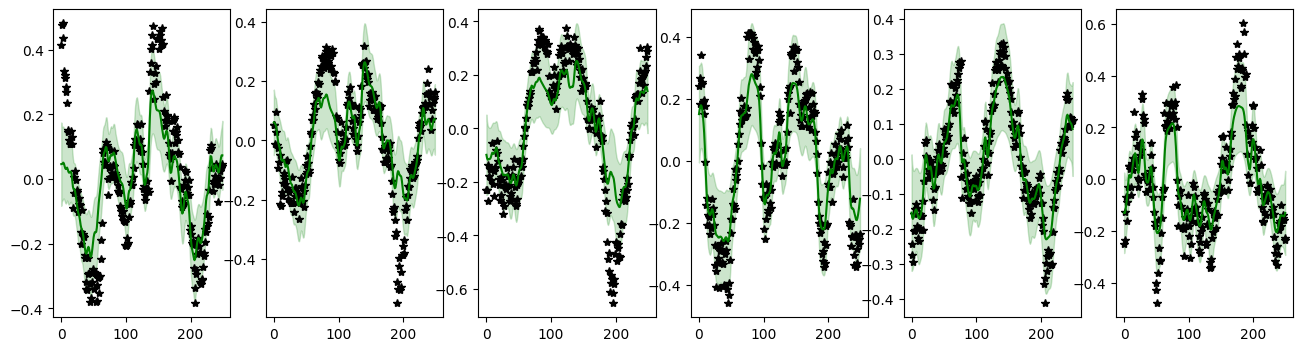

In [614]:
fig, axs = plt.subplots(1, 6, figsize=(16,4))

for i in range(6):
    axs[i].plot(ts, Ys[:, i], 'k*', label="Data")
    axs[i].plot(ts, preds_smooth[:, i], color='green', label="Fit")
    axs[i].fill_between(ts.flatten(), preds_smooth[:, i] - 2 * stds_smooth[:, i], preds_smooth[:, i] + 2 * stds_smooth[:, i], alpha=0.2, color='green')


[0.08356326 0.12766072 0.15017101 0.19438575 0.14482097 0.29939828]
[0.03942139 0.20893901 0.17003542 0.13815357 0.32146756 0.12198306]
[0.27218619 0.07625952 0.09817291 0.09235592 0.2575774  0.20344806]
[0.02129431 0.17803096 0.18415138 0.0919851  0.17702185 0.3475164 ]
[0.25926308 0.12852295 0.14373453 0.10067289 0.18782686 0.17997969]


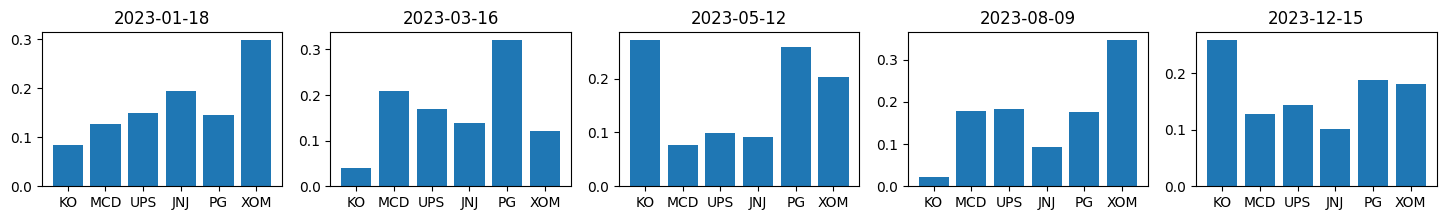

In [615]:
def portfolio_variance(weights, cov_matrix):
    weights = np.exp(weights)
    weights = weights / np.sum(weights)
    return np.dot(weights.T, np.dot(cov_matrix, weights))  # w^T Σ w

#constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Weights sum to 1
#bounds = tuple((0, 1) for _ in range(num_assets))  # No short-selling: 0 <= w_i <= 1

initial_weights = np.ones(num_assets) / num_assets

num_dates = 5
factor = 1e5

fig, axs = plt.subplots(1,num_dates, figsize=(18,2))

for i, idx in enumerate([10, 50, 90, 150, 240]):
    cov_matrix = factor * (gp.H @ Ps[1:-1][idx] @ gp.H.T)
    #cov_matrix[range(num_assets), range(num_assets)] = 1e-3
    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                    method='BFGS')
    
    ws = np.exp(result.x)
    ws = ws / np.sum(ws)
    print(ws)

    axs[i].bar(ticks.keys(), ws)
    axs[i].set_title("{}".format(data.index[idx].date()))

[2.58732581e-02 2.67419439e-01 7.91257288e-09 3.87240139e-08
 3.55210261e-01 3.51496995e-01]


<BarContainer object of 6 artists>

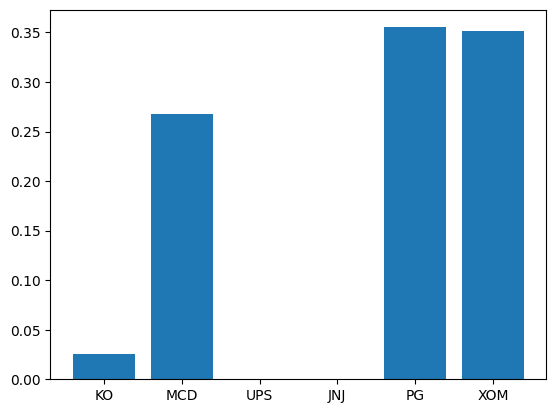

In [616]:
cov_matrix = factor * data.cov().to_numpy()

result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
            method='BFGS')

ws = np.exp(result.x)
ws = ws / ws.sum()
print(ws)

plt.bar(ticks.keys(), ws)
